## Week 8 Homework

### Q1: derive the following

1. $p(\boldsymbol \beta | \textbf{y}, \textbf{X}, \Sigma=\sigma^2 I)$ for the **linear regression model** likelihood proportional to $\exp \left(-{\frac {1}{2}}(\mathbf {y} -\mathbf{X\boldsymbol \beta})^\top \Sigma^{-1}(\mathbf {y} - \mathbf{X\boldsymbol\beta})\right)$ and a $\text{MVN}(\boldsymbol\beta_0, \boldsymbol\Sigma_\beta)$ for $\boldsymbol\beta$

2. The analytical posterior distribution for $\sigma^2$ the **error variance** of a **linear regression model** with **design matrix** $\mathbf{X}$ assuming $\sigma^2$ has an **inverse-gamma** prior distribution with parameters $\alpha^*$ and $\beta^*$ (unrelated to $\boldsymbol \beta$).

#### [Optional] Q1 Extra: derive the following

Show that for $s_i=1$ and **hyperparameters** $b_i=0$ (ignoring normalizing proportionality constants) the log posterior distributions for $\beta$ using either **normal** or **Laplace** prior distributions have analagous forms to the **ridge** and **lasso** loss functions.

*Note though that Bayesians do not optimize posterior distributions, they sample from them; but, nonetheless, the posterior distributions serve to provided 'regularizeations' of the likelihood through the prior.*

---

### Q1.1

We are given the likelihood and prior here:

Likelihood: $p(y\ |\ \beta,X,\Sigma)\propto\exp\left(-\frac12(y-X\beta)^T\Sigma^{-1}(y-X\beta)\right)$
- With $\Sigma=\sigma^2I$, it follows that: $p(y\ |\ \beta,X,\sigma^2)=N(X\beta,\sigma^2I)$

Prior for $\beta$: $p(\beta)=N(\beta_0,\Sigma_\beta)$

To find the posterior $p(\beta\ |\ y,X,\sigma^2)$, we use Bayes Theorem:

$p(\beta\ |\ y,X,\sigma^2)\propto p(y\ |\ \beta,X,\sigma^2)p(\beta)$

In this case, since both the likelihood and prior are multivariate normal distributions, their product will also result in a mulvariate normal distribution. Therefore, the posterior will be multivariate normal with the following:

$p(\beta\ |\ y,X,\sigma^2)= N(\beta_n,\Sigma_n)$
- The posterior mean is $\beta_n=\Sigma_n\left(X^T(\sigma^2I)^{-1}y+\Sigma_\beta^{-1}\beta_0\right)=\Sigma_n\left(\frac1{\sigma^2}X^Ty+\Sigma_\beta^{-1}\beta_0\right)$
- The posterior covariance is $\Sigma_n=\left(X^T(\sigma^2I)^{-1}X+\Sigma_\beta^{-1})\right)^{-1}=\left(\frac1{\sigma^2}X^TX+\Sigma_\beta^{-1}\right)^{-1}$

This confirms that the posterior distribution is $p(\beta\ |\ y,X,\sigma^2)=N(\beta_n,\Sigma_n)$

---

---

### Q1.2

We assume the following:
- Likelihood: $y\ |\ \beta,X,\sigma^2\sim N(X\beta,\sigma^2I)$
- Prior for $\sigma^2$: $\sigma^2\sim\text{Inverse-Gamma}(\alpha^*,\beta^*)$

Similarly to Q1.1, the posterior distribution in this case can be obtained through conjugacy. It results that the posterior distribution of $\sigma^2$ is: $\sigma^2\ |\ y,X\sim\text{Inverse-Gamma}(\alpha_n,\beta_n)$
- New shape parameter: $\alpha_n=\alpha^*+\frac n2$
- New scale parameter: $\beta_n=\beta^*+\frac12(y-X\beta_n)^T(y-X\beta_n)+\frac12\text{tr}(X^TX\Sigma_n)$

This confirms that the posterior distribution is $\sigma^2\ |\ y,X\sim\text{Inverse-Gamma}(\alpha_n,\beta_n)$

---

### Q2: perform Bayesian Linear Regression

- For any data set you find interesting (perhaps from kaggle.com?)
- Use an appropriate non **inverse-gamma** prior for `sigma`
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than a `pm.MvNormal` alternative
- Use `pm.Normal('y', mu=X@betas, sigma=sigma, observed=y)` rather than `pm.MvNormal` alternative
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

#### [Optional] Q2 Extra: perform generalized Bayesian Linear Regression

Replace the residual distribution and use an appropriate link function





In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/advertising.csv')

Output()

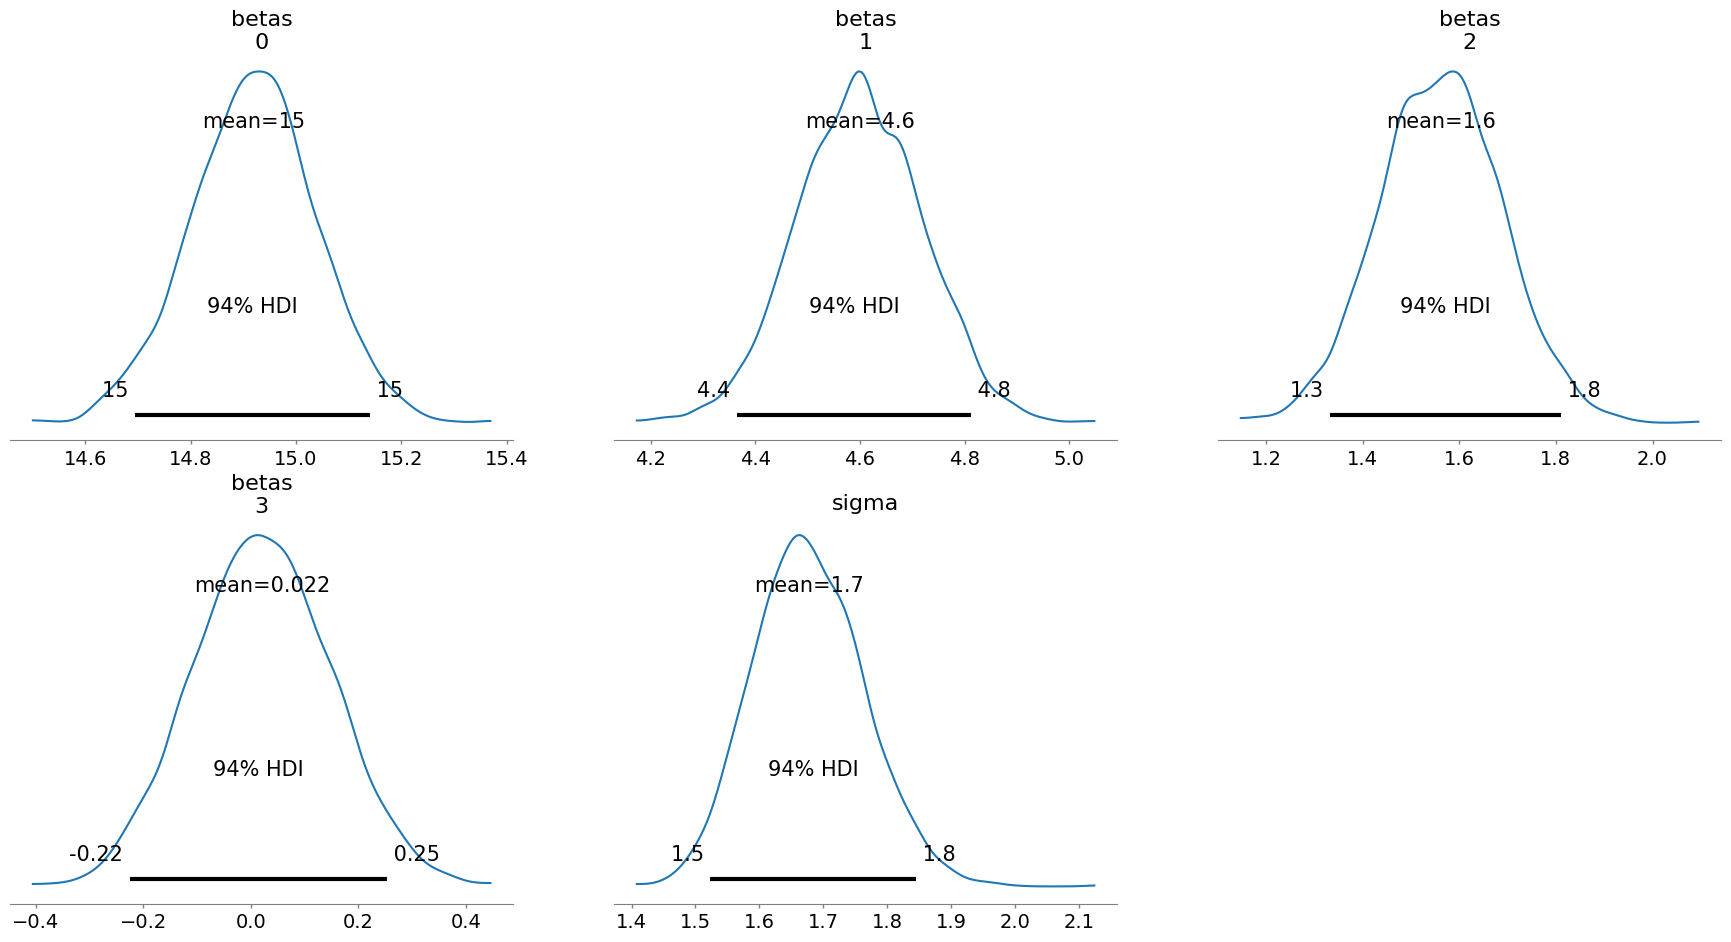


95% HDI for betas: [[14.67378496 15.14103716]
 [ 4.36431356  4.82903595]
 [ 1.33267637  1.83122724]
 [-0.21667585  0.27930139]]
95% HDI for sigma: [1.5122538  1.84671335]


In [22]:
import pandas as pd
import numpy as np
import pymc as pm  # Fixed 'pymc' import
import arviz as az
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

random.seed(365)

X = data[['TV', 'Radio', 'Newspaper']]
y = data['Sales']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.hstack((np.ones((X_scaled.shape[0], 1)), X_scaled))
n, p = X_scaled.shape
y = y.values

# Define Bayesian model
with pm.Model() as model:
    # Priors
    betas = pm.Normal("betas", mu=0, sigma=1, shape=p)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Likelihood
    mu = pm.math.dot(X_scaled, betas)  # Linear model
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # MCMC sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, cores=2)

# Posterior distributions
az.plot_posterior(trace)
plt.show()

# 95% HDI
hdi_95 = az.hdi(trace, hdi_prob=0.95)
print(f"\n95% HDI for betas: {hdi_95['betas'].values}")
print(f"95% HDI for sigma: {hdi_95['sigma'].values}")

### Q3: perform robust Bayesian Linear Regression

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\boldsymbol \beta, \tau,\tau_i)$ be $\text{N}(y_i | \textbf{X} \boldsymbol \beta, \overset{\textrm{precision}}{\tau \times \tau_i})$.

- Return to your dataset and maniputate it to have some various outliers or find another dataset with some outlier data
- Use an appropriate prior for inference on $v$ if you have enough data to do so
- Use the posterior distributions of the $\tau_i$'s to identify data point "outliers"
- Use the posterior distributions of the $\sigma_i^{-2} = \tau \times \tau_i$ to create posterior distribuitions of the **influence** (the diagonals of the $H$ "hat" matrix $X^\top (X^\top D X)^{-1} X$ where $D_{ij}=0$ and $D_{ii} = \sigma^2_i$) and compare and contras some example "outlier" versus "non outlier" data points

- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

#### [Optional] Q3 Extra: measurement error models?

What if $\textbf{x}_i = \textbf{x}_i^{true} + \eta_i, \eta_i \sim \mathcal{MVN}(\textbf{0}, \Sigma)$ for some kind of measurement error covariance structure $\Sigma$ and $\mathcal N (y_i| \textbf{X}^{true}\boldsymbol \beta, \sigma)$?

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (200) in plot_posterior, generating only 40 plots
  warnings.warn(


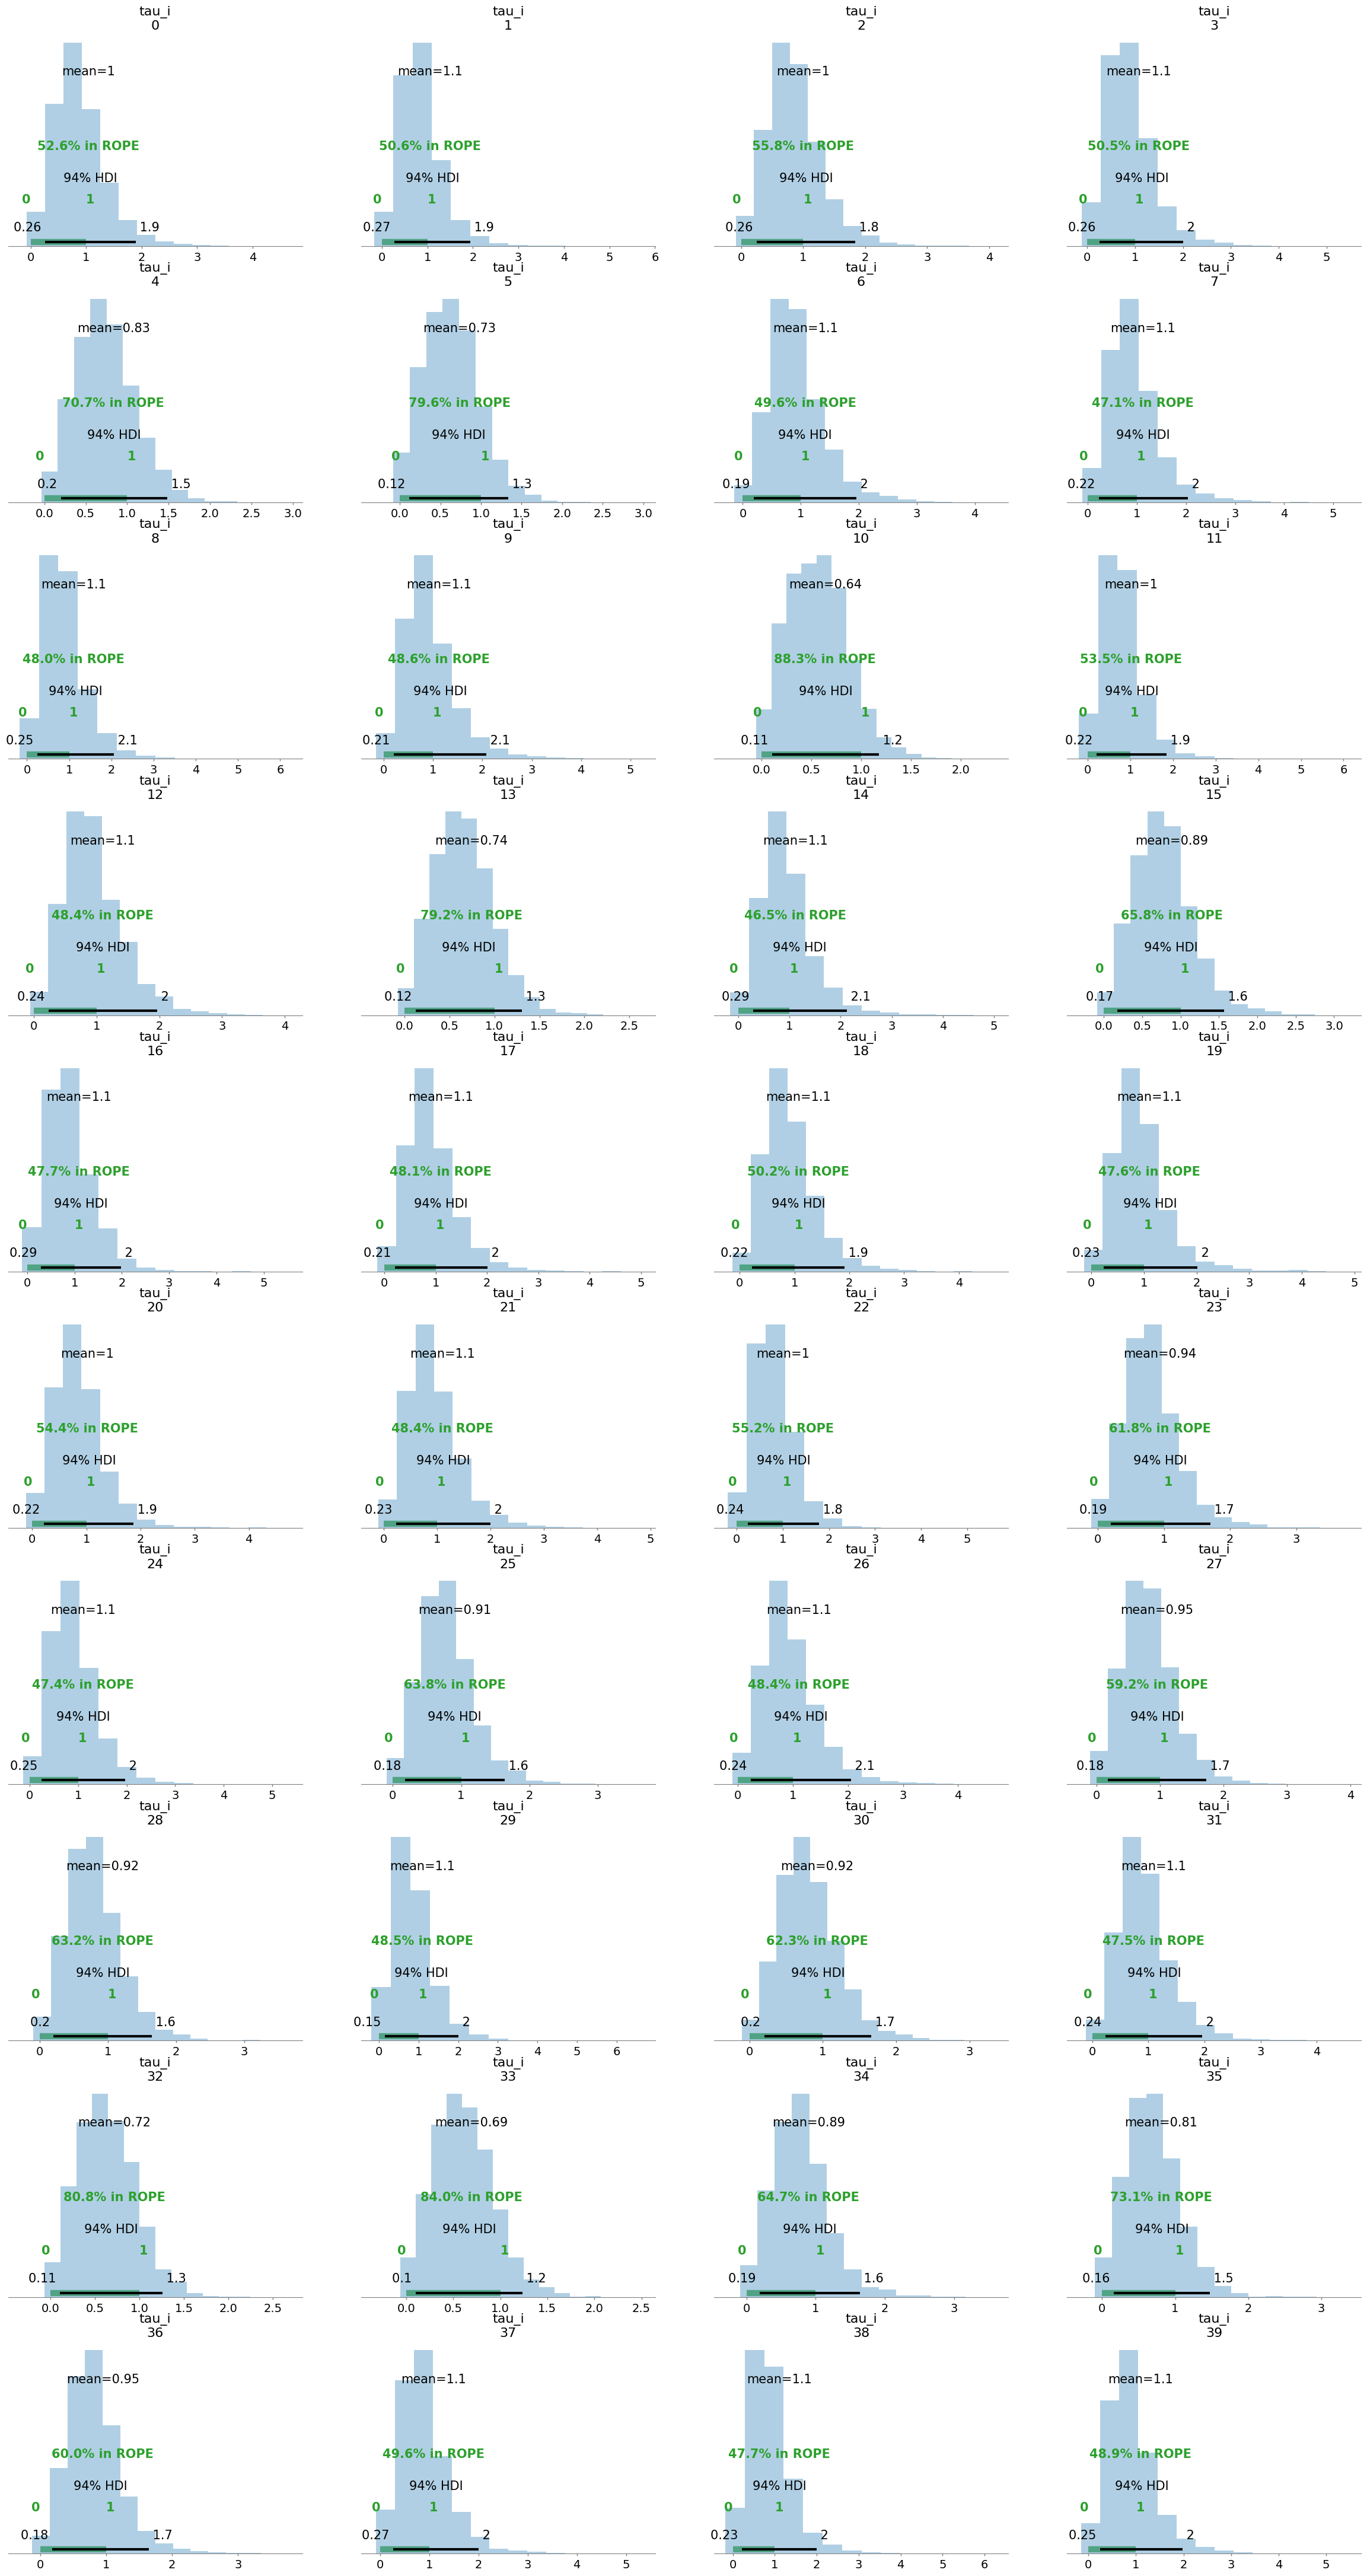

Potential Outlier Indices: [  5  10  13  32  33  55  85  97 103 113 127 128 130 150 154 155 162 179
 184 196]
Average Outlier Influence: 0.0125
Average Non-Outlier Influence: 0.0124

95% HDI for betas: [[14.73070786 15.16911987]
 [ 4.33700902  4.78588082]
 [ 1.37860616  1.86962096]
 [-0.23609032  0.22587131]]
95% HDI for sigma_i: [[0.8446921  2.32629128]
 [0.86471403 2.29704464]
 [0.85430325 2.37209646]
 [0.80498407 2.3196535 ]
 [0.97632444 2.545896  ]
 [1.05206353 2.9758628 ]
 [0.76847506 2.24158125]
 [0.78208404 2.27914469]
 [0.7457844  2.24636966]
 [0.77325281 2.24452198]
 [1.14253905 3.21539541]
 [0.86818318 2.38474997]
 [0.84230722 2.27822297]
 [1.11778277 2.84311858]
 [0.75291836 2.24491437]
 [1.00883031 2.64472865]
 [0.81880491 2.25031551]
 [0.81624257 2.30068439]
 [0.83018195 2.25846749]
 [0.76657522 2.24104655]
 [0.80421459 2.40619726]
 [0.76803777 2.24162465]
 [0.87640381 2.34373411]
 [0.92846174 2.55384605]
 [0.80207215 2.21602353]
 [0.9341268  2.49808222]
 [0.76807585 2.285

In [27]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[['TV', 'Radio', 'Newspaper']])
X_scaled = np.hstack((np.ones((X_scaled.shape[0], 1)), X_scaled))
y = data['Sales'].values
n, p = X_scaled.shape

# Define Robust Bayesian Regression Model
with pm.Model() as robust_model:
    # Priors
    tau = pm.Gamma("tau", alpha=1, beta=1)
    nu = pm.Exponential("nu", lam=1/30)
    tau_i = pm.Gamma("tau_i", alpha=nu / 2, beta=nu / 2, shape=n)

    # Regression coefficients
    betas = pm.Normal("betas", mu=0, sigma=1, shape=p)

    # Variance
    sigma_i = pm.Deterministic("sigma_i", (1 / np.sqrt(tau * tau_i)))

    # Likelihood
    mu = pm.math.dot(X_scaled, betas)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma_i, observed=y)

    # Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, cores=2)

# Posterior distribution of τ_i
az.plot_posterior(trace, var_names=["tau_i"], kind="hist", rope=(0, 1))
plt.show()

# Potential Outliers
tau_i_post = trace.posterior["tau_i"].mean(dim=["chain", "draw"])
outlier_indices = np.where(tau_i_post < np.percentile(tau_i_post, 10))[0]
print("Potential Outlier Indices:", outlier_indices)

# Compute D Matrix
D = np.diag(trace.posterior["sigma_i"].mean(dim=["chain", "draw"]).values)

# Compute Hat Matrix
H = X_scaled @ np.linalg.inv(X_scaled.T @ D @ X_scaled) @ X_scaled.T
leverage_scores = np.diag(H)

# Outliers vs Non-Outliers
outlier_leverage = leverage_scores[outlier_indices]
non_outlier_leverage = np.delete(leverage_scores, outlier_indices)
print(f"Average Outlier Influence: {np.mean(outlier_leverage):.4f}")
print(f"Average Non-Outlier Influence: {np.mean(non_outlier_leverage):.4f}")

# 95% HDI
hdi_95 = az.hdi(trace, hdi_prob=0.95)
print(f"\n95% HDI for betas: {hdi_95['betas'].values}")
print(f"95% HDI for sigma_i: {hdi_95['sigma_i'].values}")
